# Define segment and predict sales associated

## Importations of packages 

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import fsolve
import io

import pickle
import warnings

## load databases

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
type_of_activity = "sport"

In [7]:
def load_train_test(type_of_activity):
    # BUCKET = f"projet-bdc2324-team1/Generalization/{type_of_activity}"
    BUCKET = f"projet-bdc2324-team1/1_Temp/1_0_Modelling_Datasets/{type_of_activity}"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [8]:
dataset_train, dataset_test = load_train_test(type_of_activity)
dataset_train.isna().sum()

/tmp/ipykernel_427/290017524.py:8: DtypeWarning: Columns (10,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")
/tmp/ipykernel_427/290017524.py:12: DtypeWarning: Columns (10,24) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_test = pd.read_csv(file_in, sep=",")


customer_id              0
street_id                0
structure_id        222819
mcp_contact_id       70845
fidelity                 0
                     ...  
purchases_8_2021         0
purchases_8_2022         0
purchases_9_2021         0
purchases_9_2022         0
y_has_purchased          0
Length: 87, dtype: int64

In [9]:
def features_target_split(dataset_train, dataset_test):
    
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'fidelity',  'is_email_true', 'opt_in', #'is_partner', 'nb_tickets_internet',, 'vente_internet_max'
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    """
    
    X_train = dataset_train # [features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test # [features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 87)
Shape test :  (96096, 87)


## get results from the logit cross validated model

In [11]:
X_test

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0       5_4317407     969908           NaN       6156473.0         1   
1        5_477635     109121           NaN       6213652.0         2   
2        5_411639      92929           NaN       6160271.0         4   
3        5_326623      79862           NaN       6140109.0         1   
4        5_383915      85421           NaN       6149409.0         2   
...           ...        ...           ...             ...       ...   
96091     9_91205      76215           NaN         47280.0         0   
96092    9_369887     815891           NaN      30764537.0         4   
96093   9_1007562          1           NaN             NaN         0   
96094     9_15037      12992           NaN       2213448.0         0   
96095    9_135370      76215           NaN       2164740.0         0   

       tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0           1771       False         NaN           True       0  ...   
1           1771       False         NaN           True       0  ...   
2           1771       False         NaN           True       0  ...   
3           1771       False         NaN           True       1  ...   
4           1771       False         NaN           True       1  ...   
...          ...         ...         ...            ...     ...  ...   
96091       1490       False         NaN           True       1  ...   
96092       1490       False         NaN           True       0  ...   
96093       1490       False         NaN           True       0  ...   
96094       1490       False         NaN           True       1  ...   
96095       1490       False         NaN           True       1  ...   

      purchases_5_2022 purchases_6_2021  purchases_6_2022  purchases_7_2021  \
0                  0.0              0.0               0.0               0.0   
1                  0.0              0.0               0.0               0.0   
2                  0.0              0.0               0.0               0.0   
3                  0.0              0.0               0.0               0.0   
4                  0.0              0.0               0.0               0.0   
...                ...              ...               ...               ...   
96091              0.0              0.0               0.0               0.0   
96092              0.0              0.0               0.0               0.0   
96093              0.0              0.0               0.0               0.0   
96094              0.0              0.0               0.0               0.0   
96095              0.0              0.0               0.0               0.0   

       purchases_7_2022  purchases_8_2021  purchases_8_2022  purchases_9_2021  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               1.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
96091               0.0               0.0               0.0               0.0   
96092               0.0               0.0               0.0               0.0   
96093               0.0               0.0               0.0               0.0   
96094               0.0               0.0               0.0               0.0   
96095               0.0               0.0               0.0               0.0   

       purchases_9_2022  y_has_purchased  
0                   0.0              0.0  
1                   0.0              0.0  
2                   0.0              0.0  
3                   0.0              0.0  
4                   0.0              0.0  
...                 ...              ...  
96091               0.0              0.0  
96092     

In [12]:
def load_model(type_of_activity, model):
    # BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    BUCKET = f"projet-bdc2324-team1/basique/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model

In [13]:
#model = load_model(type_of_activity, "LogisticRegression_Benchmark")
# model = load_model(type_of_activity, "randomF_cv")
model = load_model(type_of_activity, "LogisticRegression_cv")
model

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_campaigns',
                                                                          'taux_ouverture_mail',
                                                                          'prop_purchases_internet',
                                                                          'nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'pu...
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01]),
                         'LogisticRegression_cv__class_weight': ['balanced',
                                                                 {0.0: 0.5834990214856762,
                                                                  1.0: 3.49404706249026}],
                         'LogisticRegression_cv__penalty': ['l1', 'l2']},
             scoring=make_scorer(recall_score, response_method='predict'))

## Quartile clustering

In [14]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [15]:
X_test_segment = X_test

X_test_segment["has_purchased"] = y_test
X_test_segment["has_purchased_estim"] = y_pred
X_test_segment["score"] = y_pred_prob
X_test_segment["quartile"] = np.where(X_test['score']<0.25, '1',
                   np.where(X_test['score']<0.5, '2',
                   np.where(X_test['score']<0.75, '3', '4')))
X_test_segment.head(10)

customer_id  street_id  structure_id  mcp_contact_id  fidelity  tenant_id  \
0   5_4317407     969908           NaN       6156473.0         1       1771   
1    5_477635     109121           NaN       6213652.0         2       1771   
2    5_411639      92929           NaN       6160271.0         4       1771   
3    5_326623      79862           NaN       6140109.0         1       1771   
4    5_383915      85421           NaN       6149409.0         2       1771   
5    5_233172     141401           NaN          3324.0         1       1771   
6    5_389999      95759           NaN       6151025.0         1       1771   
7   5_4292211      78897           NaN       4729841.0         1       1771   
8    5_353553      84189           NaN       6146995.0         1       1771   
9    5_401296       3491           NaN       6155457.0         1       1771   

   is_partner  deleted_at  is_email_true  opt_in  ... purchases_7_2022  \
0       False         NaN           True       0  ...              0.0   
1       False         NaN           True       0  ...              0.0   
2       False         NaN           True       0  ...              0.0   
3       False         NaN           True       1  ...              0.0   
4       False         NaN           True       1  ...              0.0   
5       False         NaN           True       1  ...              0.0   
6       False         NaN           True       0  ...              0.0   
7       False         NaN           True       1  ...              0.0   
8       False         NaN           True       1  ...              0.0   
9       False         NaN           True       0  ...              0.0   

  purchases_8_2021  purchases_8_2022  purchases_9_2021  purchases_9_2022  \
0              0.0               0.0               0.0               0.0   
1              0.0               0.0               0.0               0.0   
2              0.0               0.0               0.0               0.0   
3              0.0               0.0               1.0               0.0   
4              0.0               0.0               0.0               0.0   
5              0.0               0.0               0.0               1.0   
6              0.0               0.0               0.0               0.0   
7              0.0               0.0               0.0               0.0   
8              0.0               0.0               0.0               0.0   
9              0.0               0.0               0.0               0.0   

   y_has_purchased  has_purchased  has_purchased_estim     score  quartile  
0              0.0            0.0                  0.0  0.445019         2  
1              0.0            0.0                  0.0  0.382586         2  
2              0.0            0.0                  1.0  0.916747         4  
3              0.0            0.0                  0.0  0.090534         1  
4              0.0            0.0                  0.0  0.346571         2  
5              0.0            0.0                  1.0  0.924684         4  
6              0.0            0.0                  1.0  0.569031         3  
7              0.0            0.0                  0.0  0.125622         1  
8              0.0            0.0                  0.0  0.229432         1  
9              0.0            0.0                  1.0  0.503987         3  

[10 rows x 91 columns]

In [16]:
def df_segment(df, y, model) :

    y_pred = model.predict(df)
    y_pred_prob = model.predict_proba(df)[:, 1]

    df_segment = df

    df_segment["has_purchased"] = y
    df_segment["has_purchased_estim"] = y_pred
    df_segment["score"] = y_pred_prob
    df_segment["quartile"] = np.where(df_segment['score']<0.25, '1',
                       np.where(df_segment['score']<0.5, '2',
                       np.where(df_segment['score']<0.75, '3', '4')))

    return df_segment

In [88]:
df_segment(X_test, y_test, model)

/tmp/ipykernel_1080/2624515794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased"] = y
/tmp/ipykernel_1080/2624515794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased_estim"] = y_pred
/tmp/ipykernel_1080/2624515794.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  opt_in  \
0                   0.000000                  0.0         1  ...   False   
1                   0.000000                  0.0         2  ...    True   
2                   0.000000                  0.0         2  ...    True   
3                   0.000000                  0.0         1  ...   False   
4                 363.061678                  0.0         4  ...   False   
...                      ...                  ...       ...  ...     ...   
96091               0.000000                  1.0         2  ...   False   
96092               0.000000                  1.0         1  ...   False   
96093              -1.000000                  0.0         1  ...    True   
96094               0.000000                  1.0         1  ...   False   
96095              -1.000000                  0.0         2  ...   False   

       gender_female  gender_male  gender_other  nb_campaigns  \
0                  1            0             0           0.0   
1                  0            1             0           0.0   
2                  1            0             0           0.0   
3                  1            0             0           0.0   
4                  1            0             0           0.0   
...              ...          ...           ...           ...   
96091              0            1             0          15.0   
96092              0            1             0          12.0   
96093              1            0             0          29.0   
96094              0            1             0          20.0   
96095              0            1             0          31.0   

       nb_campaigns_opened  has_purchased  has_purchased_estim     score  \
0                      0.0            0.0                  0.0  0.006066   
1                      0.0            1.0                  0.0  0.288847   
2                      0.0            0.0                  0.0  0.103264   
3                      0.0            0.0                  0.0  0.008928   
4                      0.0            1.0                  1.0  0.992809   
...                    ...            ...                  ...       ...   
96091                  5.0            1.0                  0.0  0.351762   
96092                  9.0            0.0                  1.0  0.567814   
96093                  3.0            0.0                  0.0  0.0

## definition of functions to compute the bias of scores and adjust it 

Le biais est calculé de la façon suivante. 
En notant $\hat{p(x_i)}$ le score calculé (estimé par la modélisation) et $p(x_i)$ le vrai score (sans biais), et $\beta$ le logarithme du biais, on a : \
$\ln{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}} = \beta + \ln{\frac{p(x_i)}{1-p(x_i)}}$ \
$ \frac{\hat{p(x_i)}}{1-\hat{p(x_i)}} = \exp(\beta) . \frac{p(x_i)}{1-p(x_i)} $ , soit : \
$p(x_i) = {\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}}$ \
Ce qu'on appelle biais et qu'on estime dans le code par la suite est : $B=\exp(\beta) $. Les probabilités ne sont donc pas biaisées si $B=1$. Il y a surestimation si $B>1$. 

On cherche le B qui permette d'ajuster les probabilités de telle sorte que la somme des scores soit égale à la somme des y_has_purchased. Cela revient à résoudre : 

\begin{equation}
\sum_{i}{\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}} = \sum_{i}{Y_i}
\end{equation}

C'est ce que fait la fonction find_bias. 

Note sur les notations : \
$\hat{p(x_i)}$ correspond à ce qu'on appelle le score et $p(x_i)$ à ce qu'on appellera le score adjusted

In [17]:
# compute adjusted score from odd ratios (cf formula above)
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [18]:
# when the score is 1 we cannot compute the odd ratio, so we adjust scores equal to 1
# we set the second best score instead

def adjust_score_1(score) :
    second_best_score = np.array([element for element in score if element !=1]).max()
    new_score = np.array([element if element!=1 else second_best_score for element in score])    
    return new_score

In [19]:
def odd_ratio(score) :
    return score / (1 - score)

In [20]:
# definition of a function that automatically detects the bias

def find_bias(odd_ratios, y_objective, initial_guess=6) :
    """
    results = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    initial_guess , method = "BFGS")

    estimated_bias = results.x[0]
    """

    # faster method
    bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
 
    return bias_estimated[0]

In [21]:
print(X_test_segment["score"].mean(), y_test["y_has_purchased"].mean())
y_train["y_has_purchased"].mean()

0.31861289893787315 0.14317973692973693


0.14310053386734936

In [22]:
# computation with the function defined

bias_test_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_test_segment["score"])), 
                           y_objective = y_test["y_has_purchased"].sum(),
                           initial_guess=6)
bias_test_set

5.939748066330849

In [23]:
# comparison with bias of the train set
X_train_score = model.predict_proba(X_train)[:, 1]

bias_train_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_train_score)), 
                           y_objective = y_train["y_has_purchased"].sum(),
                           initial_guess=10)
bias_train_set

6.01952986090399

In [24]:
print("betâ test - betâ train = ",np.log(bias_test_set/bias_train_set))

betâ test - betâ train =  -0.013342440676233564


In [25]:
# impact of considering a bias computed on train set instead of test set - totally neglectable

score_adjusted_test = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)
score_adjusted_train = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)

print("mean absolute erreur",abs(score_adjusted_test-score_adjusted_train).mean())

mean absolute erreur 0.0009061459618344602


In [26]:
# adjust scores accordingly 

# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)

# actually, we are not supposed to have X_test, so the biais is estimated on X_train
# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)
X_test_segment["score_adjusted"] = score_adjusted_train

In [27]:
# check 

MSE_score = ((X_test_segment["score"]-X_test_segment["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test_segment["score_adjusted"]-X_test_segment["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for ajusted score : {MSE_ajusted_score}")

print("sum of y_has_purchased :",y_test["y_has_purchased"].sum())
print("sum of adjusted scores :", X_test_segment["score_adjusted"].sum())

MSE for score : 0.11809894130837426
MSE for ajusted score : 0.07434720017843571
sum of y_has_purchased : 13759.0
sum of adjusted scores : 13671.922997651252


In [28]:
# mean absolute error - divided by 2 with out method

MAE_score = abs(X_test_segment["score"]-X_test_segment["has_purchased"]).mean()
MAE_ajusted_score = abs(X_test_segment["score_adjusted"]-X_test_segment["has_purchased"]).mean()
print(f"MAE for score : {MAE_score}")
print(f"MAE for adjusted score : {MAE_ajusted_score}")

MAE for score : 0.24742788848313355
MAE for adjusted score : 0.14205672428104504


In [30]:
# visualization

# histogramme des probas et des probas ajustées

def plot_hist_scores(df, score, score_adjusted, type_of_activity) :

    plt.figure()
    plt.hist(df[score], label = "score", alpha=0.6)
    plt.hist(df[score_adjusted], label="adjusted score", alpha=0.6)
    plt.legend()
    plt.xlabel("probability of a future purchase")
    plt.ylabel("count")
    plt.title(f"Comparison between score and adjusted score for {type_of_activity} companies")
    # plt.show()

In [64]:
PATH + file_name + type_of_activity + ".png"

'projet-bdc2324-team1/Output_expected_CA/sport/hist_score_adjustedsport.png'

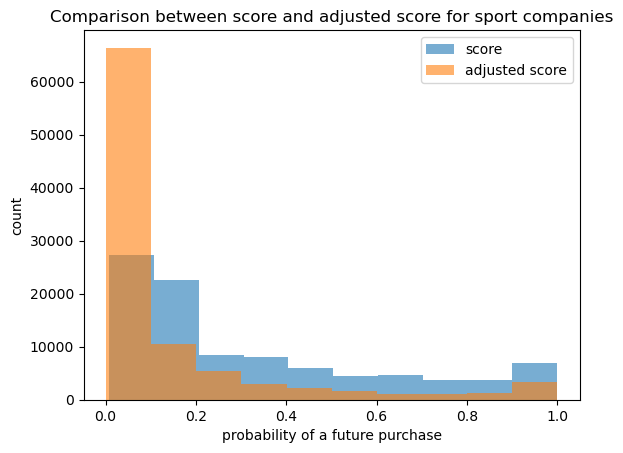

In [31]:
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

In [40]:
# define path so save graphics

# define type of activity 
type_of_activity = "sport"
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
print(PATH)

projet-bdc2324-team1/Output_expected_CA/sport/


In [68]:
# export png 

# plot adjusted scores and save (to be tested)
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)
file_name = "hist_score_adjusted_"
FILE_PATH_OUT_S3 = PATH + file_name + type_of_activity + ".png"
with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

## Compute number of tickets and CA by segment with the recalibrated score

In [32]:
X_test_table_adjusted_scores = (100 * X_test_segment.groupby("quartile")[["score","score_adjusted", "has_purchased"]].mean()).round(2).reset_index()
X_test_table_adjusted_scores = X_test_table_adjusted_scores.rename(columns = {col : f"{col.replace('_', ' ')} (%)" for col in X_test_table_adjusted_scores.columns if col in ["score","score_adjusted", "has_purchased"]})
X_test_table_adjusted_scores

quartile  score (%)  score adjusted (%)  has purchased (%)
0        1      10.20                1.94               1.19
1        2      37.08                9.12              10.62
2        3      62.07               22.00              28.67
3        4      90.35               67.16              63.09

In [162]:
X_test_table_adjusted_scores.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\nquartile & score (%) & score adjusted (%) & has purchased (%) \\\\\n\\midrule\n1 & 13.250000 & 2.510000 & 1.570000 \\\\\n2 & 33.890000 & 8.000000 & 9.850000 \\\\\n3 & 63.060000 & 22.580000 & 21.470000 \\\\\n4 & 90.520000 & 66.200000 & 65.010000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [43]:
# comparison between score and adjusted score - export csv associated

file_name = "table_adjusted_score_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_table_adjusted_scores.to_csv(file_out, index = False)

In [129]:
def project_tickets_CA (df, nb_purchases, nb_tickets, total_amount, score_adjusted, duration_ref, duration_projection) :
    
    duration_ratio = duration_ref/duration_projection

    df_output = df
    
    # project number of tickets : at least 1 ticket purchased if the customer purchased
    df_output.loc[:,"nb_tickets_projected"] = df_output.loc[:,nb_tickets].apply(lambda x : max(1, x /duration_ratio))

    # project amount : if the customer buys a ticket, we expect the amount to be at least the average price of tickets 
    # for customers purchasing exactly one ticket
    if df_output.loc[df_output[nb_tickets]==1].shape[0] > 0 :
        avg_price = df_output.loc[df_output[nb_tickets]==1][total_amount].mean()
    else :
        avg_price = df_output[total_amount].mean()
    # df_output.loc[:,"total_amount_projected"] = df_output.loc[:,total_amount] / duration_ratio
    # df_output.loc[:,"total_amount_projected"] = df_output.loc[:,total_amount].apply(lambda x : max(avg_ticket_price, x/duration_ratio))

    # we compute the avg price of ticket for each customer
    df_output["avg_ticket_price"] = df_output[total_amount]/df_output[nb_tickets]

    # correct negatives total amounts
    df_output.loc[:,"total_amount_corrected"] = np.where(df_output[total_amount] < 0, 
                                                         avg_price * df_output[nb_tickets],
                                                         df_output[total_amount])
    
    df_output.loc[:,"total_amount_projected"] = np.where(
        # if no ticket bought in the past, we take the average price
        df_output[nb_tickets]==0, avg_price,
        # if avg prices of tickets are negative, we recompute the expected amount based on the avg price of a ticket
        # observed on the whole population
        np.where(X_test_segment["avg_ticket_price"] < 0, avg_price * df_output.loc[:,"nb_tickets_projected"],
        # else, the amount projected is the average price of tickets bought by the customer * nb tickets projected
                 df_output["avg_ticket_price"] * df_output.loc[:,"nb_tickets_projected"])
        )
    
    df_output.loc[:,"nb_tickets_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"nb_tickets_projected"]
    df_output.loc[:,"total_amount_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"total_amount_projected"]

    df_output.loc[:,"pace_purchase"] = (duration_ref/df_output.loc[:,nb_purchases]).apply(lambda x : np.nan if x==np.inf else x)
    
    return df_output


In [120]:
np.where(X_test_segment["total_amount"] < 0, avg_price * X_test_segment["nb_tickets"],
         X_test_segment["total_amount"]
)

array([25., 92., 45., ...,  0.,  0.,  0.])

In [121]:
 X_test_segment["total_amount"]

0         25.00
1         92.00
2         45.00
3         10.00
4        127.00
          ...  
96091      0.00
96092    100.89
96093      0.00
96094      0.00
96095      0.00
Name: total_amount, Length: 96096, dtype: float64

In [105]:
X_test_segment.loc[X_test_segment["nb_tickets"]==-1].shape[0°

(0, 98)

In [71]:
duration_ratio = 17/12
X_test_segment.loc[X_test_segment["nb_tickets"]>0]["total_amount"].describe()

count    4.410500e+04
mean     4.640310e+02
std      1.049793e+04
min     -2.064700e+04
25%      3.000000e+01
50%      6.900000e+01
75%      1.339900e+02
max      1.209751e+06
Name: total_amount, dtype: float64

In [74]:
avg_price = X_test_segment.loc[X_test_segment["nb_tickets"]==1]["total_amount"].mean()
X_test_segment["total_amount"].apply(lambda x : max(avg_price, x/duration_ratio)).describe()

count     96096.000000
mean        183.851977
std        5021.379770
min          48.713098
25%          48.713098
50%          48.713098
75%          48.713098
max      853942.164706
Name: total_amount, dtype: float64

In [76]:
X_test_segment["total_amount"].apply(lambda x : x/duration_ratio).describe()

count     96096.000000
mean        150.335598
std        5022.896337
min      -14574.352941
25%           0.000000
50%           0.000000
75%          42.352941
max      853942.164706
Name: total_amount, dtype: float64

In [57]:
X_test_segment.loc[:,"nb_tickets"]/duration_ratio

0        1.411765
1        1.411765
2        2.117647
3        0.705882
4        5.647059
           ...   
96091    0.000000
96092    1.411765
96093    0.000000
96094    0.000000
96095    0.000000
Name: nb_tickets, Length: 96096, dtype: float64

In [81]:
pd.Series(np.where(X_test_segment["nb_tickets"]==0, avg_price, X_test_segment["nb_tickets_projected"] * X_test_segment["total_amount"]/X_test_segment["nb_tickets"])).describe()

count     96096.000000
mean        176.690937
std        5022.166115
min      -14574.352941
25%          48.713098
50%          48.713098
75%          48.713098
max      853942.164706
dtype: float64

In [87]:
X_test_segment[X_test_segment["total_amount"]<0]["nb_tickets"].describe()

count     162.000000
mean       51.283951
std       135.183724
min         1.000000
25%         2.000000
50%         6.000000
75%        31.500000
max      1038.000000
Name: nb_tickets, dtype: float64

In [89]:
# code pr projet revenue

X_test_segment["avg_ticket_price"] = X_test_segment["total_amount"]/X_test_segment["nb_tickets"]
X_test_segment["avg_ticket_price"].describe()

count    44105.000000
mean        35.661188
std         71.477667
min       -216.368182
25%         10.000000
50%         25.000000
75%         48.720000
max       4000.000000
Name: avg_ticket_price, dtype: float64

In [97]:
pd.Series(
    np.where(X_test_segment["nb_tickets"]==0, avg_price,
         
         np.where(X_test_segment["avg_ticket_price"] < 0, avg_price * X_test_segment["nb_tickets"] / duration_ratio,
        X_test_segment["avg_ticket_price"] * X_test_segment["nb_tickets"] / duration_ratio)
        )
).describe()

count     96096.000000
mean        180.394197
std        5025.591726
min           0.000000
25%          48.713098
50%          48.713098
75%          48.713098
max      853942.164706
dtype: float64

In [100]:
X_test_segment[X_test_segment["avg_ticket_price"] == 0]["nb_tickets"].describe()

count    5058.000000
mean       13.671807
std       155.341970
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      8250.000000
Name: nb_tickets, dtype: float64

In [ ]:
df['colonne2'] = np.where(df['colonne1'] > seuil2, df['colonne2'] * 2,  # Si colonne1 > seuil2
                          np.where(df['colonne1'] > seuil1, df['colonne2'] + 1, df['colonne2'])) 

In [132]:
# project nb tickets and CA

X_test_segment = project_tickets_CA (X_test_segment, "nb_purchases", "nb_tickets", "total_amount", "score_adjusted", 
                                     duration_ref=17, duration_projection=12)
X_test_segment

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0       5_4317407     969908           NaN       6156473.0         1   
1        5_477635     109121           NaN       6213652.0         2   
2        5_411639      92929           NaN       6160271.0         4   
3        5_326623      79862           NaN       6140109.0         1   
4        5_383915      85421           NaN       6149409.0         2   
...           ...        ...           ...             ...       ...   
96091     9_91205      76215           NaN         47280.0         0   
96092    9_369887     815891           NaN      30764537.0         4   
96093   9_1007562          1           NaN             NaN         0   
96094     9_15037      12992           NaN       2213448.0         0   
96095    9_135370      76215           NaN       2164740.0         0   

       tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0           1771       False         NaN           True       0  ...   
1           1771       False         NaN           True       0  ...   
2           1771       False         NaN           True       0  ...   
3           1771       False         NaN           True       1  ...   
4           1771       False         NaN           True       1  ...   
...          ...         ...         ...            ...     ...  ...   
96091       1490       False         NaN           True       1  ...   
96092       1490       False         NaN           True       0  ...   
96093       1490       False         NaN           True       0  ...   
96094       1490       False         NaN           True       1  ...   
96095       1490       False         NaN           True       1  ...   

          score quartile  score_adjusted  nb_tickets_projected  \
0      0.445019        2        0.117551              1.411765   
1      0.382586        2        0.093333              1.411765   
2      0.916747        4        0.646556              2.117647   
3      0.090534        1        0.016268              1.000000   
4      0.346571        2        0.080976              5.647059   
...         ...      ...             ...                   ...   
96091  0.014966        1        0.002518              1.000000   
96092  0.834257        4        0.455392              1.411765   
96093  0.062886        1        0.011025              1.000000   
96094  0.068998        1        0.012162              1.000000   
96095  0.018486        1        0.003119              1.000000   

       total_amount_projected  nb_tickets_expected  total_amount_expected  \
0                   17.647059             0.165955               2.074432   
1                   64.941176             0.131765               6.061181   
2                   31.764706             1.369178              20.537670   
3                   10.000000             0.016268               0.162683   
4                   89.647059             0.457279               7.259298   
...                       ...                  ...                    ...   
96091               48.713098             0.002518               0.122642   
96092               71.216471             0.642906              32.431379   
96093               48.713098             0.011025               0.537071   
96094               48.713098             0.012162               0.592451   
96095               48.713098             0.003119               0.151938   

       pace_purchase  avg_ticket_price  total_amount_corrected  
0          17.000000            12.500                   25.00  
1           8.500000            46.000                   92.00  
2           5.666667            15.000                   45.00  
3          17.000000            10.000                   10.00  
4           8.500000            15.875                  127.00  
...              ...               ...                     ...  
96091            NaN               NaN                    0.00  
96092       8.500000            50.445

In [124]:
X_test_segment["total_amount_corrected"].describe()

count    9.609600e+04
mean     2.182217e+02
std      7.120650e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.100000e+01
max      1.209751e+06
Name: total_amount_corrected, dtype: float64

In [111]:
X_test_segment["avg_ticket_price"].describe()

count    44105.000000
mean        35.661188
std         71.477667
min       -216.368182
25%         10.000000
50%         25.000000
75%         48.720000
max       4000.000000
Name: avg_ticket_price, dtype: float64

In [113]:
(X_test_segment["total_amount_projected"]==0).mean()

0.052634865134865136

In [115]:
X_test_segment["nb_tickets_projected"].describe()

count    96096.000000
mean         4.442483
std         64.952589
min          1.000000
25%          1.000000
50%          1.000000
75%          1.411765
max      11472.000000
Name: nb_tickets_projected, dtype: float64

In [35]:
X_test_segment.groupby("quartile")["pace_purchase"].mean()

quartile
1    15.330011
2    15.314322
3    14.031588
4     8.562546
Name: pace_purchase, dtype: float64

In [128]:
(X_test[((X_test["total_amount_corrected"] - X_test["total_amount"])>0)]["total_amount_corrected"]
 -X_test[((X_test["total_amount_corrected"] - X_test["total_amount"])>0)]["total_amount"]) .describe()

count      162.000000
mean      3112.018089
std       8392.717823
min         51.843098
25%        161.889295
50%        395.635139
75%       2141.696184
max      69988.895986
dtype: float64

In [118]:
# generalization with a function

def summary_expected_CA(df, segment, nb_tickets_expected, total_amount_expected, total_amount, pace_purchase,
                       duration_ref=17, duration_projection=12) :
    
    # compute nb tickets estimated and total amount expected
    df_expected_CA = df.groupby(segment)[[nb_tickets_expected, total_amount_expected]].sum().reset_index()
    
    # number of customers by segment
    df_expected_CA.insert(1, "size", df.groupby(segment).size().values)
    
    # size in percent of all customers
    df_expected_CA.insert(2, "size_perct", 100 * df_expected_CA["size"]/df_expected_CA["size"].sum())
    
    # compute share of CA recovered
    duration_ratio=duration_ref/duration_projection
    
    df_expected_CA["revenue_recovered_perct"] = 100 * duration_ratio * df_expected_CA[total_amount_expected] / \
    df.groupby(segment)[total_amount].sum().values

    df_expected_CA["share_future_revenue_perct"] = 100 * duration_ratio * df_expected_CA[total_amount_expected] / \
    df[total_amount].sum()

    df_drop_null_pace = df.dropna(subset=[pace_purchase])
    df_expected_CA["pace_purchase"] = df_drop_null_pace.groupby(segment)[pace_purchase].mean().values
    
    return df_expected_CA

In [133]:
"""
X_test_expected_CA = round(summary_expected_CA(df=X_test_segment, segment="quartile", 
                    nb_tickets_expected="nb_tickets_expected", total_amount_expected="total_amount_expected", 
                    total_amount="total_amount", pace_purchase="pace_purchase"),2)
                    """
X_test_expected_CA = round(summary_expected_CA(df=X_test_segment, segment="quartile", 
                    nb_tickets_expected="nb_tickets_expected", total_amount_expected="total_amount_expected", 
                    total_amount="total_amount_corrected", pace_purchase="pace_purchase"),2)
X_test_expected_CA

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  54123       56.32              1480.36               55345.21   
1        2  18181       18.92              4381.84              130503.26   
2        3  11111       11.56              8827.97              285945.50   
3        4  12681       13.20            239758.61            10313321.91   

   revenue_recovered_perct  share_future_revenue_perct  pace_purchase  
0                    11.99                        0.37          15.33  
1                    11.65                        0.88          15.31  
2                    24.00                        1.93          14.03  
3                    85.74                       69.67           8.56

In [116]:
print(X_test_segment["nb_tickets_projected"].describe())
X_test_segment["nb_tickets_expected"].describe()


count    96096.000000
mean         4.442483
std         64.952589
min          1.000000
25%          1.000000
50%          1.000000
75%          1.411765
max      11472.000000
Name: nb_tickets_projected, dtype: float64


count    96096.000000
mean         2.647860
std         59.108910
min          0.001335
25%          0.015281
50%          0.044399
75%          0.230742
max      11450.589975
Name: nb_tickets_expected, dtype: float64

In [117]:
# we can recover share future revenue by multipling the share of amount by quartile * revenue recovered
X_test_segment.groupby("quartile")["total_amount"].sum()/X_test_segment["total_amount"].sum()

quartile
1    0.029070
2    0.074526
3    0.078737
4    0.817668
Name: total_amount, dtype: float64

In [64]:
# Création du dictionnaire de mapping pour les noms de colonnes
mapping_dict = {col: col.replace("perct", "(%)").replace("_", " ") for col in X_test_expected_CA.columns}

X_test_expected_CA.rename(columns=mapping_dict).to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\nquartile & size & size (%) & nb tickets expected & total amount expected & revenue recovered (%) & pace purchase \\\\\n\\midrule\n1 & 53626 & 35.310000 & 398.260000 & 13949.330000 & 2.350000 & 16.480000 \\\\\n2 & 55974 & 36.860000 & 3113.770000 & 101639.450000 & 6.240000 & 16.470000 \\\\\n3 & 30435 & 20.040000 & 6214.350000 & 208267.220000 & 14.270000 & 15.710000 \\\\\n4 & 11839 & 7.800000 & 72929.460000 & 1835702.430000 & 75.380000 & 11.480000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [122]:
# export summary table to the MinIO storage

file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_expected_CA.to_csv(file_out, index = False)

In [53]:
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_expected_CA/musique/table_expected_CA_musique.csv'

## Test : vizu tables saved

In [66]:
path = 'projet-bdc2324-team1/Output_expected_CA/sport/table_adjusted_scoresport.csv'

with fs.open( path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",")
df

quartile  score (%)  score adjusted (%)  has purchased (%)
0         1      13.25                2.51               1.57
1         2      33.89                8.00               9.85
2         3      63.06               22.58              21.47
3         4      90.52               66.20              65.01

## Just to try, same computation with score instead of score adjusted

seems overestimated : if only 14% of customers come back, how can we recover 22% of the revenue from the segment that is least likely to buy ?? ...

In [80]:
X_test_segment_bis = project_tickets_CA (X_test_segment, "nb_tickets", "total_amount", "score", duration_ref=1.5, duration_projection=1)

X_test_expected_CA_bis = round(summary_expected_CA(df=X_test_segment_bis, segment="quartile", nb_tickets_expected="nb_tickets_expected", 
                    total_amount_expected="total_amount_expected", total_amount="total_amount"),2)

X_test_expected_CA_bis

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  37410       38.93               419.76                9245.08   
1        2  29517       30.72             11549.06              296522.02   
2        3  20137       20.96             29997.85              954751.91   
3        4   9032        9.40            244655.82            10736011.95   

   perct_revenue_recovered  
0                    21.71  
1                    39.24  
2                    63.34  
3                    97.72

In [81]:
print("overall share of revenue recovered : ", round(100 * duration_ratio * X_test_expected_CA_bis["total_amount_expected"].sum() / \
X_test_segment_bis["total_amount"].sum(),2), "%")

overall share of revenue recovered :  90.26 %


## Last pieces of analysis

In [161]:
# global revenue recovered
global_revenue_recovered = round(100 * duration_ratio * X_test_expected_CA["total_amount_expected"].sum() / \
X_test_segment["total_amount"].sum(),2)
print(f"overall share of revenue recovered : {global_revenue_recovered}%")

overall share of revenue recovered : 77.64%


In [163]:
100 * X_test_expected_CA["total_amount_expected"]/X_test_expected_CA["total_amount_expected"].sum()

0     0.018093
1     0.721519
2     3.336101
3    95.924287
Name: total_amount_expected, dtype: float64

In [166]:
# le segment 4 représente 83% du CA actuel et 96% du CA lié aux anciens clients pour l'année prochaine
100 * X_test_segment.groupby("quartile")["total_amount"].sum()/X_test_segment["total_amount"].sum()

quartile
1     0.320407
2     5.685020
3    11.339715
4    82.654858
Name: total_amount, dtype: float64

In [177]:
X_test_segment["total_amount"].describe() # total amount négatif ???


count     96096.000000
mean        207.475735
std        4720.046248
min      -48831.800000
25%           0.000000
50%           0.000000
75%          60.000000
max      624890.000000
Name: total_amount, dtype: float64

In [184]:
np.cumsum(X_test_segment["total_amount"].sort_values()).reset_index()["total_amount"]

0       -4.883180e+04
1       -6.483180e+04
2       -7.683860e+04
3       -8.683860e+04
4       -9.683860e+04
             ...     
96091    1.802247e+07
96092    1.839238e+07
96093    1.877219e+07
96094    1.931270e+07
96095    1.993759e+07
Name: total_amount, Length: 96096, dtype: float64